In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [6]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix , accuracy_score,precision_score,recall_score

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

# 1. Extract data


In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# %cd /content/drive/My Drive/Colab Notebooks

In [9]:
shutil.rmtree('data-set')
shutil.rmtree('data')

In [10]:
ls

data-set.zip                 Projects_ResNet50.ipynb
IMG_25621201_211946.jpg      Test.ipynb
NEW/                         trained_model_ResNet50_6.31E-04.pkl
Projects_ResNet50_e42.ipynb


In [11]:
files = zf.ZipFile("data-set.zip",'r')
files.extractall()
files.close()

In [12]:
os.listdir(os.path.join(os.getcwd(),"data-set"))

['glass', 'plastic', 'metal', 'trash']

# 2. Organize images into different folders

In [13]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    # train = random.sample(list(range(1,n+1)),int(.5*n))
    train = random.sample(list(range(1,n+1)),int(.8*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+" ("+str(i)+").jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [14]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['glass','metal','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('data-set',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [15]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/home/weerayuth/ImTrash/data')

In [16]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

In [17]:
data

ImageDataBunch;

Train: LabelList (3040 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
glass,glass,glass,glass,glass
Path: /home/weerayuth/ImTrash/data;

Valid: LabelList (380 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
glass,glass,glass,glass,glass
Path: /home/weerayuth/ImTrash/data;

Test: LabelList (380 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /home/weerayuth/ImTrash/data

In [18]:
print(data.classes)

['glass', 'metal', 'plastic', 'trash']


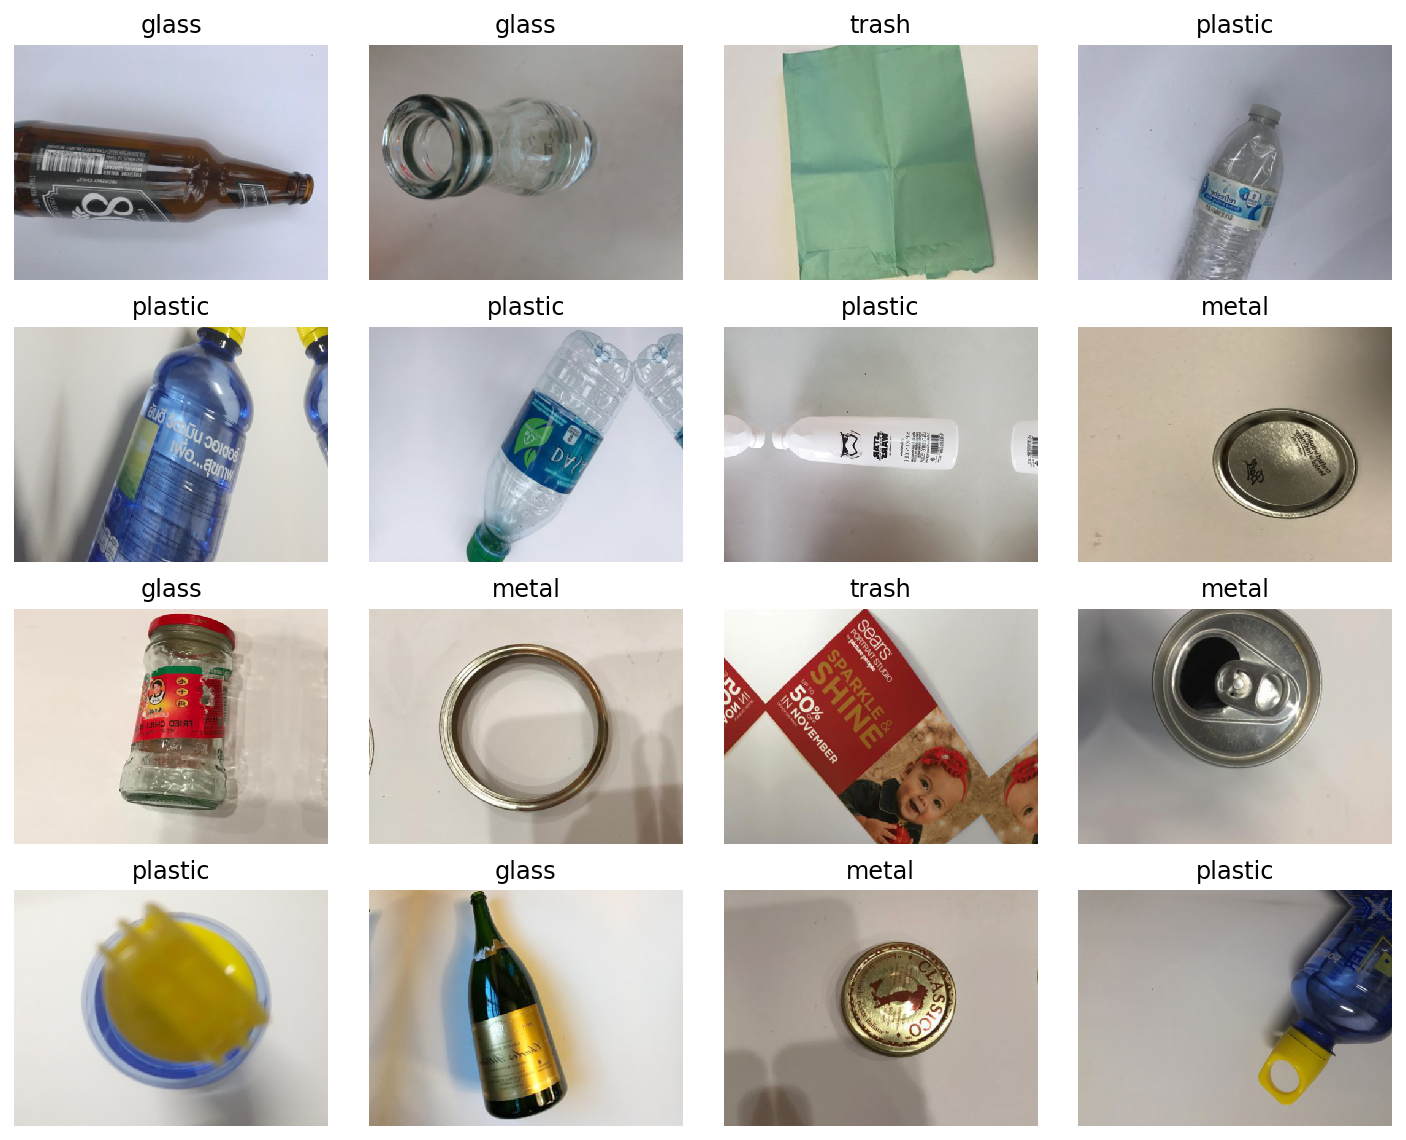

In [19]:
data.show_batch(rows=4,figsize=(10,8))

# 3. Model training

In [20]:
# learn = create_cnn(data,models.resnet34,metrics=error_rate)
learn = create_cnn(data,models.resnet50,metrics=error_rate)

/home/weerayuth/anaconda3/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [21]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

### Finding a learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.41E-04
Min loss divided by 10: 8.32E-04


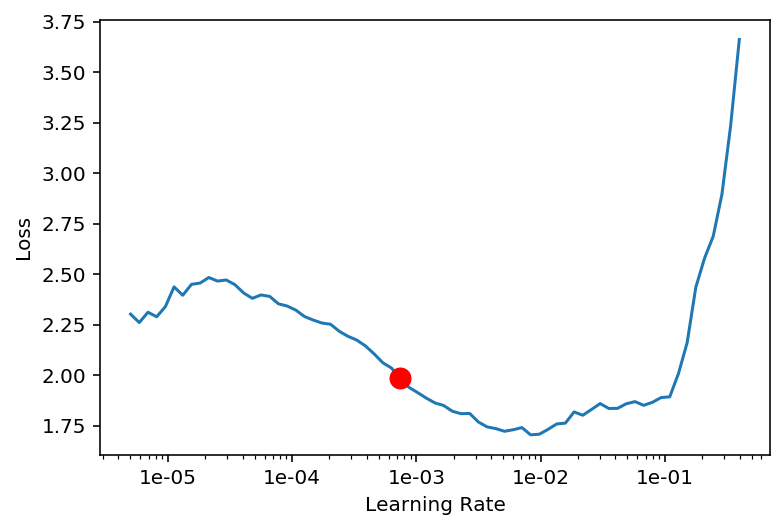

In [22]:
# learn.lr_find(start_lr=5.13e-03,end_lr=5.13e-04)
learn.lr_find(start_lr=1e-6,end_lr=1e1)
# learn.recorder.plot()
# https://docs.fast.ai/callbacks.lr_finder.html
learn.recorder.plot(suggestion=True)

### Training

In [23]:
import time
t0 = time.time()
# learn.fit_one_cycle(20,max_lr=5.13e-03)    #original
# learn.fit_one_cycle(20,max_lr=3.72E-03)    #ResNet34
# learn.fit_one_cycle(20,max_lr=5.01E-06)    #ResNet50 time1
learn.fit_one_cycle(40,max_lr=7.41E-04) 
t = time.time()
print(t-t0)

1869.7612302303314


### Visualizing most incorrect images

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

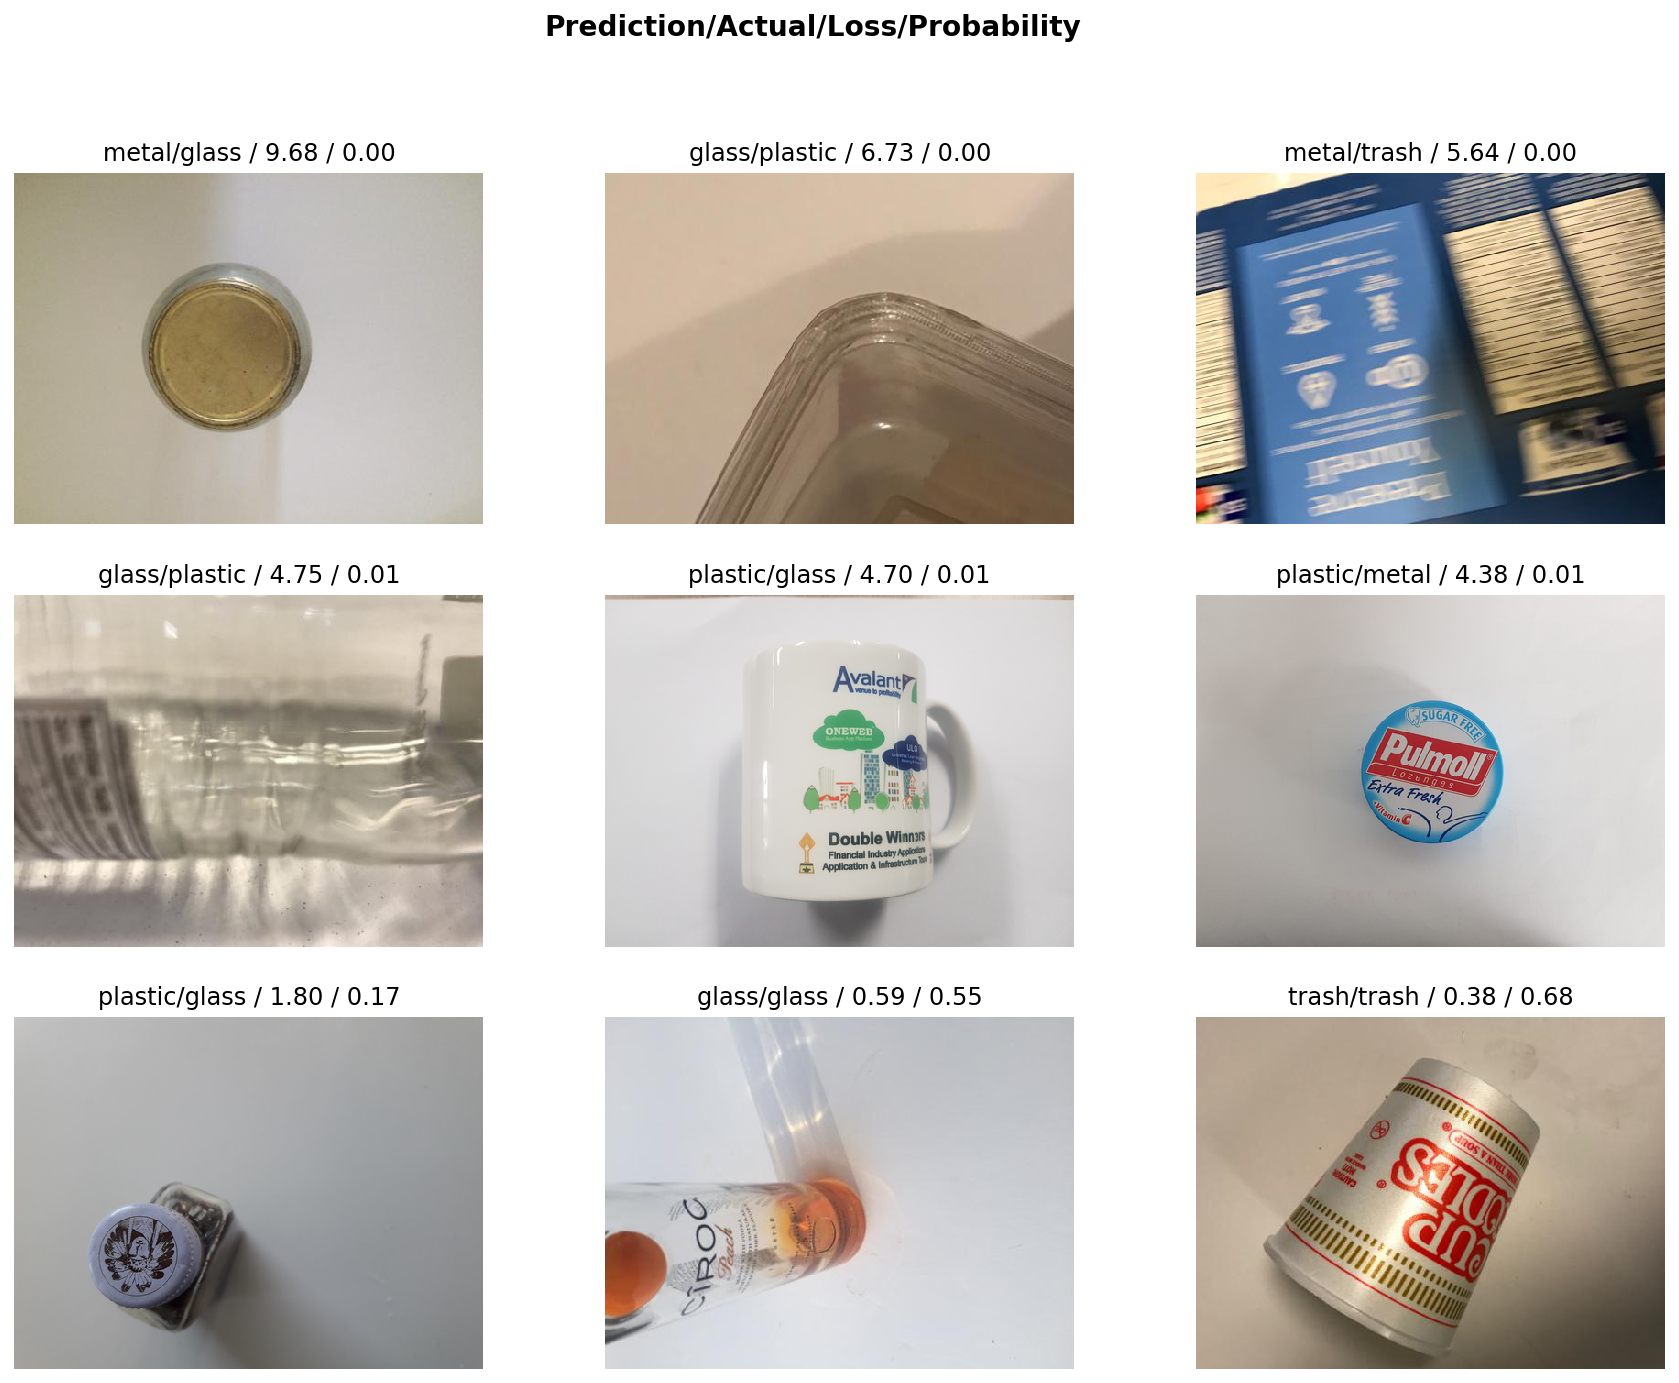

In [25]:
interp.plot_top_losses(9, figsize=(15,11))

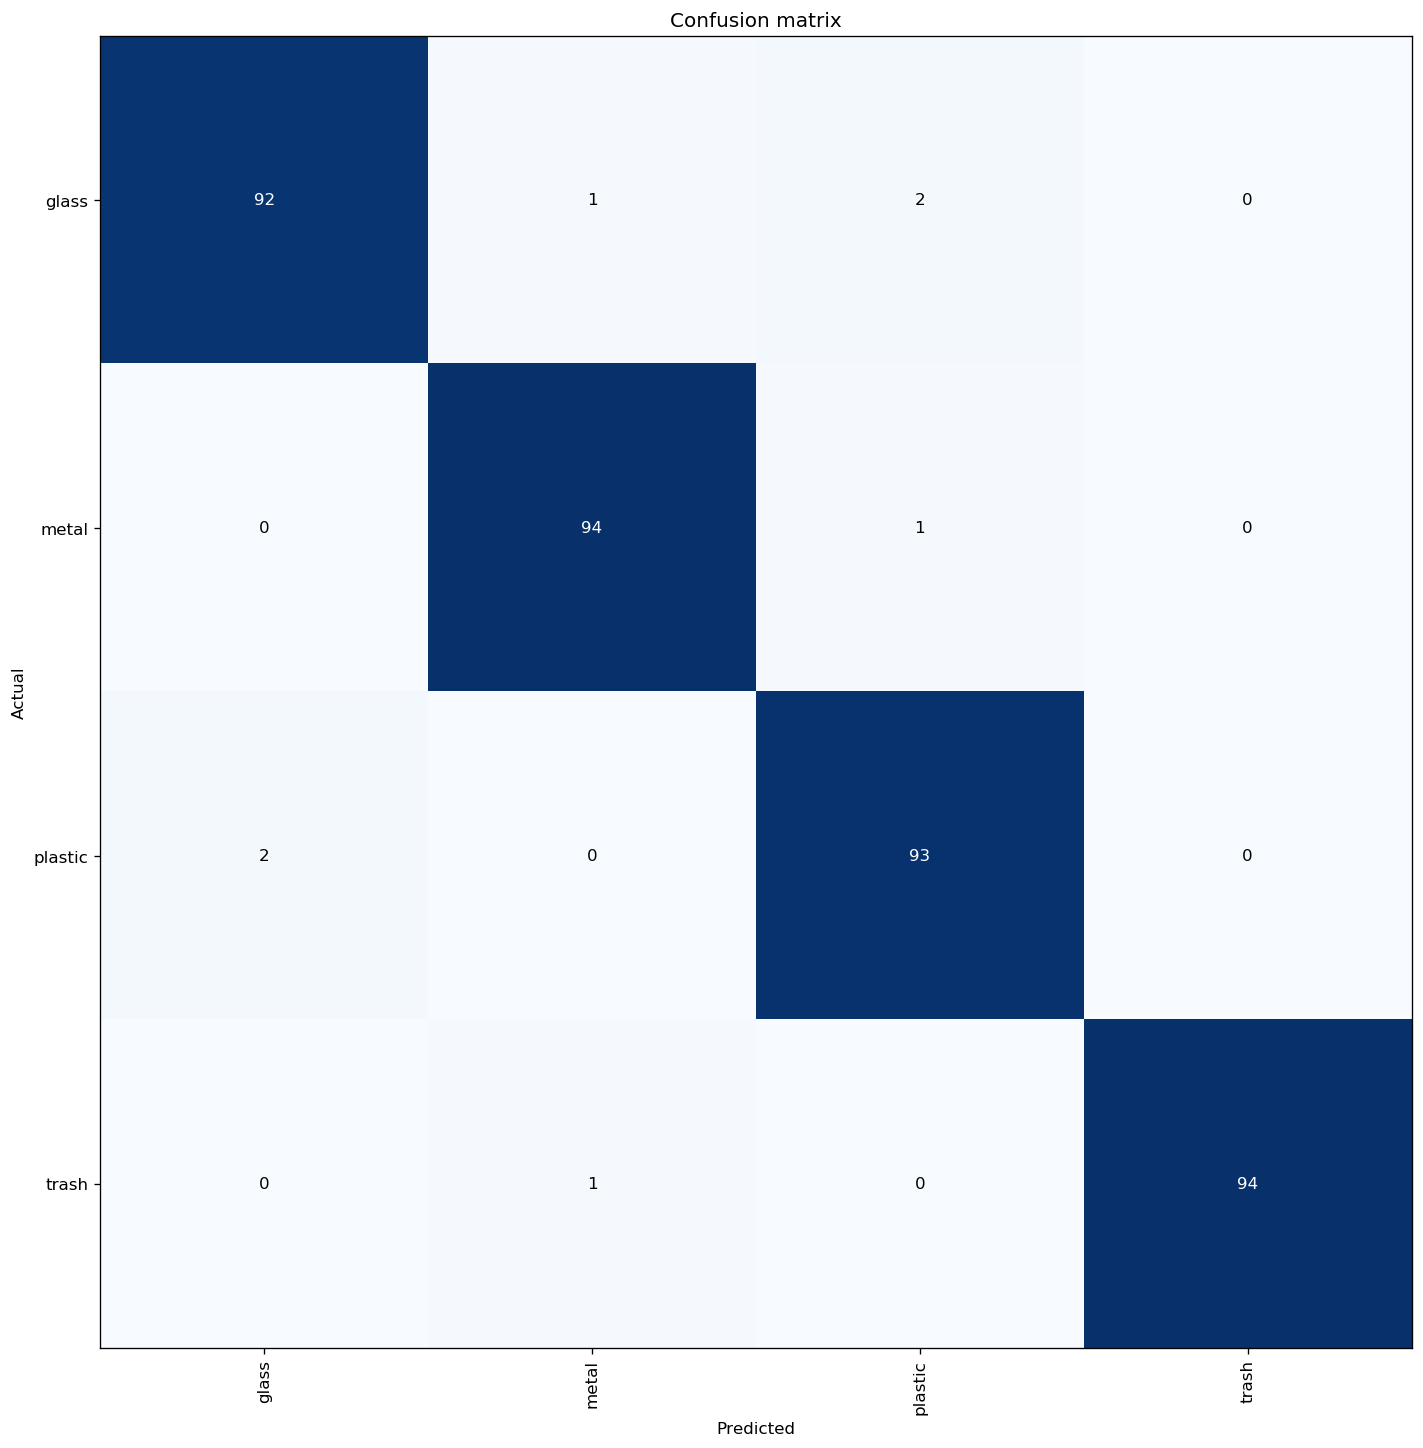

In [26]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [27]:
interp.most_confused(min_val=2)

[('glass', 'plastic', 2), ('plastic', 'glass', 2)]

# 4. Make new predictions on test data




In [28]:
preds = learn.get_preds(ds_type=DatasetType.Test)


In [29]:
print(preds[0].shape)
preds[0]

torch.Size([380, 4])


tensor([[4.4800e-07, 9.9926e-01, 4.4720e-06, 7.3388e-04],
        [2.2494e-05, 9.9309e-01, 1.5654e-06, 6.8846e-03],
        [1.2629e-04, 9.9089e-01, 1.0116e-05, 8.9707e-03],
        ...,
        [1.8062e-07, 1.5172e-07, 3.5752e-08, 1.0000e+00],
        [9.0885e-10, 4.4711e-07, 2.2279e-08, 1.0000e+00],
        [3.9015e-05, 2.5036e-06, 6.8003e-05, 9.9989e-01]])

In [30]:
data.classes

['glass', 'metal', 'plastic', 'trash']

In [31]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [32]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [33]:
yhat

['metal',
 'metal',
 'metal',
 'metal',
 'glass',
 'plastic',
 'metal',
 'plastic',
 'trash',
 'glass',
 'plastic',
 'plastic',
 'plastic',
 'trash',
 'glass',
 'metal',
 'trash',
 'glass',
 'metal',
 'trash',
 'glass',
 'metal',
 'glass',
 'trash',
 'plastic',
 'trash',
 'plastic',
 'trash',
 'trash',
 'metal',
 'metal',
 'glass',
 'metal',
 'metal',
 'plastic',
 'trash',
 'plastic',
 'metal',
 'plastic',
 'metal',
 'metal',
 'metal',
 'plastic',
 'trash',
 'metal',
 'glass',
 'plastic',
 'plastic',
 'plastic',
 'metal',
 'glass',
 'trash',
 'plastic',
 'trash',
 'glass',
 'trash',
 'metal',
 'trash',
 'plastic',
 'metal',
 'glass',
 'glass',
 'glass',
 'plastic',
 'trash',
 'metal',
 'metal',
 'trash',
 'trash',
 'plastic',
 'glass',
 'glass',
 'plastic',
 'glass',
 'metal',
 'plastic',
 'trash',
 'metal',
 'metal',
 'glass',
 'metal',
 'glass',
 'trash',
 'plastic',
 'metal',
 'metal',
 'plastic',
 'plastic',
 'metal',
 'plastic',
 'metal',
 'plastic',
 'metal',
 'plastic',
 'glass'

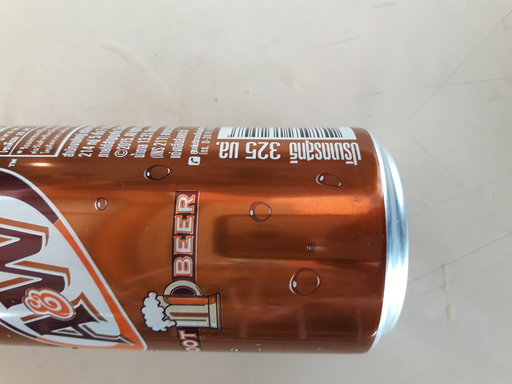

In [34]:
learn.data.test_ds[0][0]

In [35]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
# pattern = re.compile("([a-z]+\s[(][0-9]+[)])")
pattern = re.compile("([a-z]+)(\s[(][0-9]+[)])")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [36]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['metal', 'metal', 'metal', 'metal', 'glass']
['metal', 'metal', 'metal', 'metal', 'glass']


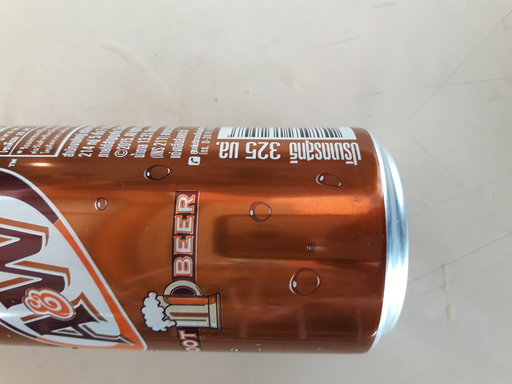

In [37]:
learn.data.test_ds[0][0]

### Test confusion matrix

In [38]:
cm = confusion_matrix(y,yhat)
print(cm)

[[92  1  2  0]
 [ 0 94  1  0]
 [ 0  0 94  1]
 [ 0  0  1 94]]


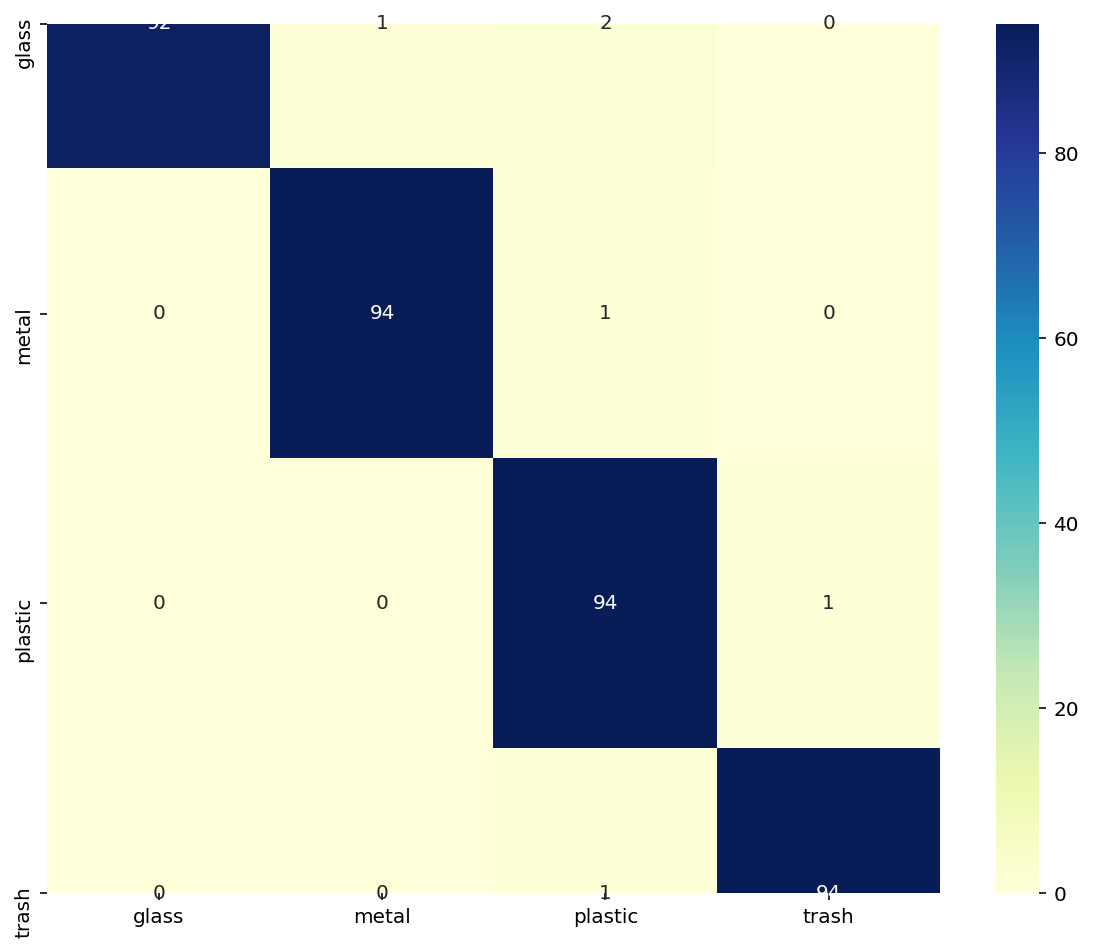

In [39]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [40]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [41]:
accuracy = correct/sum(sum(cm))
accuracy

0.9842105263157894

In [42]:
learn.save("trained_model")

In [43]:
learn.export()

In [44]:
# learn.export('trained_model2.pkl')
learn.export('trained_model_ResNet50_6.31E-04.pkl')   #ResNet50 epoch50


In [45]:
# path = learn.path
# path

In [46]:
## delete everything when you're done to save space
# shutil.rmtree("data")
# shutil.rmtree('dataset-resized')

In [47]:

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [48]:

# !nvidia-smi

# Confusion Metrix


In [49]:
# save confusion matrix and slice into four pieces
# confusion = metrics.confusion_matrix(y, yhat)
print(cm)
#[row, column]
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

[[92  1  2  0]
 [ 0 94  1  0]
 [ 0  0 94  1]
 [ 0  0  1 94]]


### Classification Accuracy

In [50]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(accuracy_score(y, yhat))

0.9946524064171123
0.9842105263157894


### Classification Error


In [51]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - accuracy_score(y, yhat))

0.0053475935828877
0.015789473684210575


### precision

In [52]:
precision = TP / float(TP + FP)

print(precision)
print(precision_score(y, yhat, average='macro'))

0.9894736842105263
0.9845327604726101


### recall

In [53]:
recall = TP / float(TP + FN)

print(recall)
print(recall_score(y, yhat, average='macro'))

1.0
0.9842105263157894


# 4. Make new predictions on test data 222


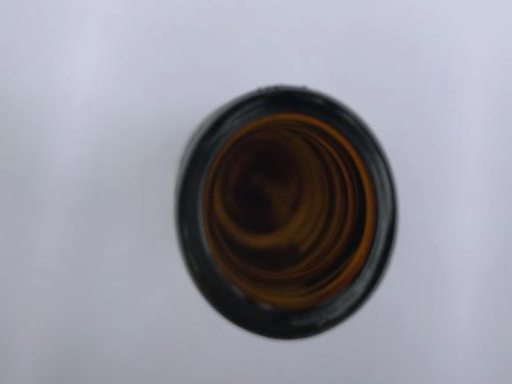

In [54]:
learn.data.train_ds[0][0]

In [55]:
learn.data.classes

['glass', 'metal', 'plastic', 'trash']

In [56]:
data2 = learn.data.train_ds[0][0]

In [57]:
preds2 = learn.predict(data2)
preds2

(Category glass,
 tensor(0),
 tensor([9.9993e-01, 6.5669e-05, 3.4561e-06, 8.5426e-08]))

In [58]:
data3 = open_image('IMG_25621201_211946.jpg')
data3 = data3.resize((3,384,512))

# learn.predict(img.data)

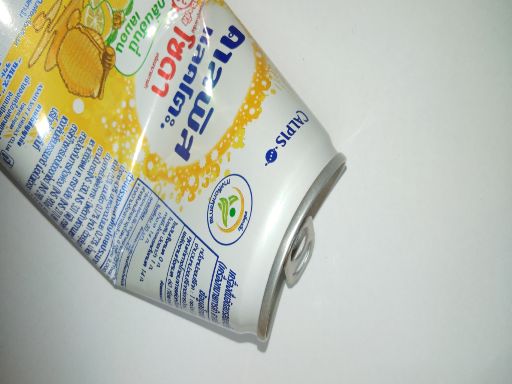

In [59]:
data3

In [60]:
preds3 = learn.predict(data3)
preds3

(Category metal, tensor(1), tensor([0.0804, 0.8971, 0.0010, 0.0214]))